In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as sts

In [5]:
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open(file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

**EXERCISE 1**

In [26]:
class OrderBook:
    
    def __init__(self, data, low, high):
        self.data = data[1]
        self.time = data[0]
        self.low = low
        self.high = high
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        # Clean data
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)
        
        # Demand and supply curves
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        # Equilibrium
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        # Prep data for estimation
        self.orders_orig = orders
        self.Q0 = self.orders_orig['Q']
        self.P0 = self.orders_orig.index.values
        
        self.orders = orders[(orders.index > low * self.midpoint) & (orders.index < high * self.midpoint)]
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope0, intercept0, r_val0, p_val0, std_err0 = sts.linregress(self.P0, self.Q0)
        self.gamma0 = intercept0
        self.beta0 = slope0
        self.p0 = - self.gamma0/self.beta0
        self.ratio0 = self.beta0
        
        slope, intercept, r_val, p_val, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot(self, name):
        fig = plt.figure(figsize=(8,6))
        
        plt.plot(self.demand.index.values, self.demand['QD'], label='Demand')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Supply')
        
        p_grid0 = np.linspace(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.plot(p_grid0, self.gamma0 + self.beta0 * p_grid0, label='Full Estimated Equation')
        
        p_grid = np.linspace(self.low * self.midpoint, self.high * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Restrictied Estimated Equation')
        
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(name + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("Full Estimation of p_0: %f" %self.p0)
        print("Restricted Estimation of p_0: %f" %self.p)
        print("Realization of BBO midpoint: %f" %self.midpoint)
        

In [27]:
def show_orderbook(file_obj, t, name):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot(name)
    test.compare()

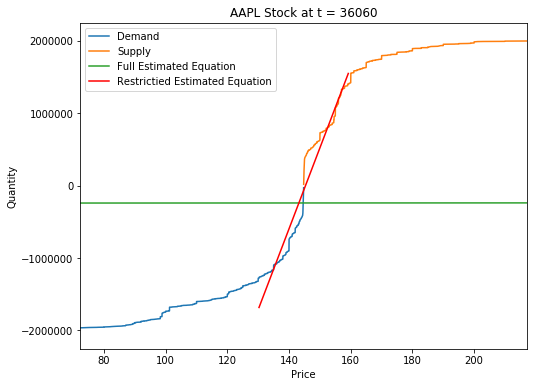

Full Estimation of p_0: 16910.274166
Restricted Estimation of p_0: 145.332400
Realization of BBO midpoint: 144.730000


In [28]:
show_orderbook(file_objs[0], 30, 'AAPL')

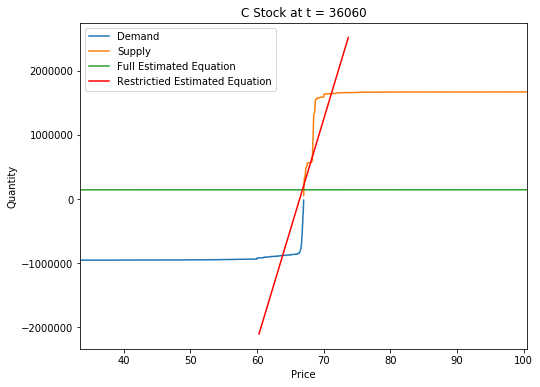

Full Estimation of p_0: -18759.358207
Restricted Estimation of p_0: 66.376474
Realization of BBO midpoint: 66.980000


In [29]:
show_orderbook(file_objs[1], 30, 'C')

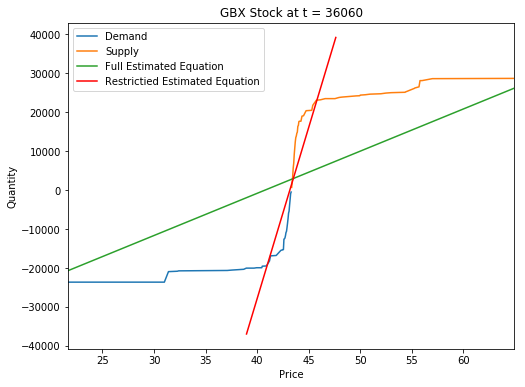

Full Estimation of p_0: 40.767251
Restricted Estimation of p_0: 43.172306
Realization of BBO midpoint: 43.300000


In [30]:
show_orderbook(file_objs[2], 30, 'GBX')

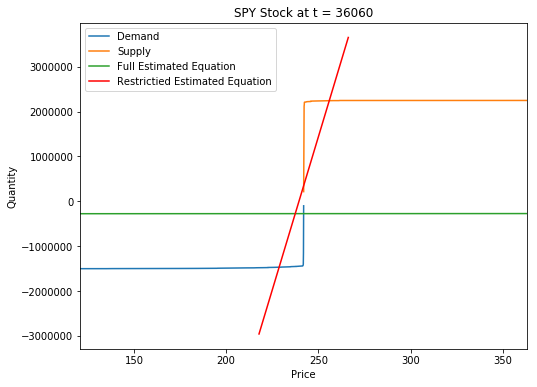

Full Estimation of p_0: 21625.121452
Restricted Estimation of p_0: 239.503527
Realization of BBO midpoint: 242.050000


In [31]:
show_orderbook(file_objs[3], 30, 'SPY')

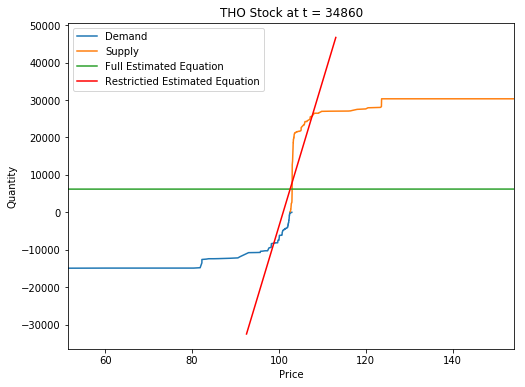

Full Estimation of p_0: -50872.567651
Restricted Estimation of p_0: 100.966398
Realization of BBO midpoint: 102.810000


In [32]:
show_orderbook(file_objs[4], 10, 'THO')

As discussed in class, the linear model only fits well for the linear sections of the orderbooks. In particular, the function tends to be linear near the point where demand equals supply. 
The model does not fit well at extreme prices. Consequently, including these data into the estimation causes bias in the estimation: overestimation for prices below the equilibrium and underestimation above.

**EXERCISE 2**

In [34]:
def plot_ex2(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        ratio[ii] = book.ratio
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.show()

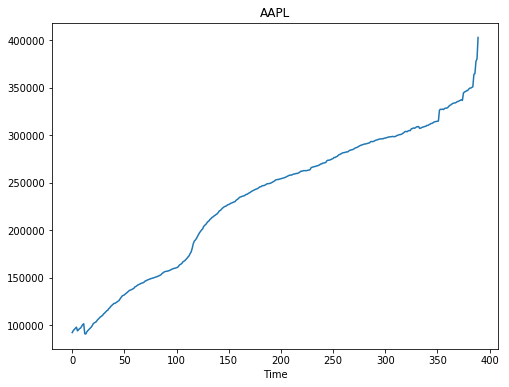

In [36]:
plot_ex2(file_objs[0], 'AAPL')

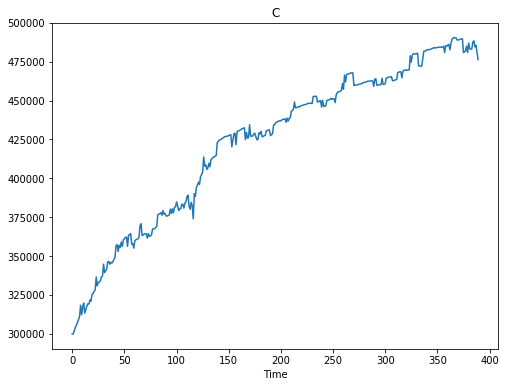

In [37]:
plot_ex2(file_objs[1], 'C')

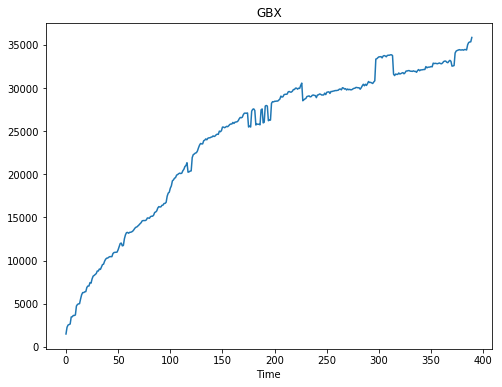

In [38]:
plot_ex2(file_objs[2], 'GBX')

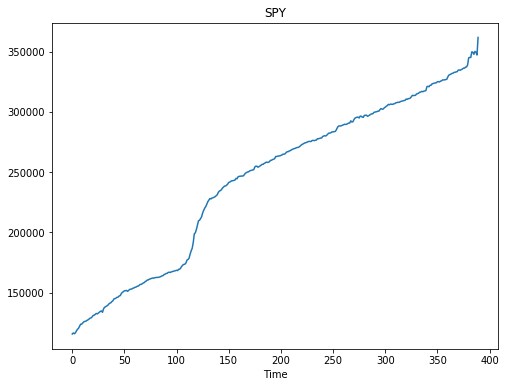

In [39]:
plot_ex2(file_objs[3], 'SPY')

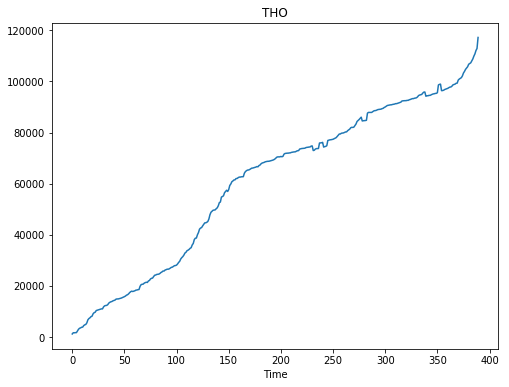

In [40]:
plot_ex2(file_objs[4], 'THO')

**EXERCISE 3**

In [44]:
def ex3(file_obj, title, cutval=1):
    p_est = np.zeros(len(file_obj))
    p_act = np.zeros(len(file_obj))
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        p_est[ii] = book.p
        p_act[ii] = book.midpoint
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(p_est, label='Estimated')
    plt.plot(p_act, label='Actual')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.show()

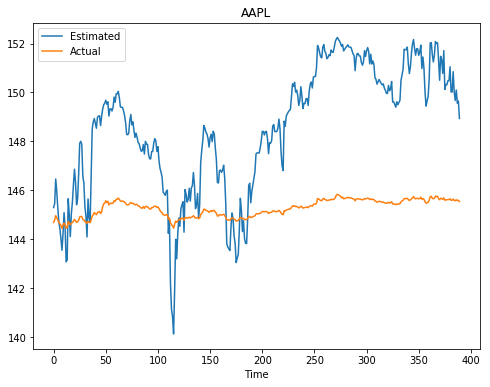

In [45]:
ex3(file_objs[0], 'AAPL')

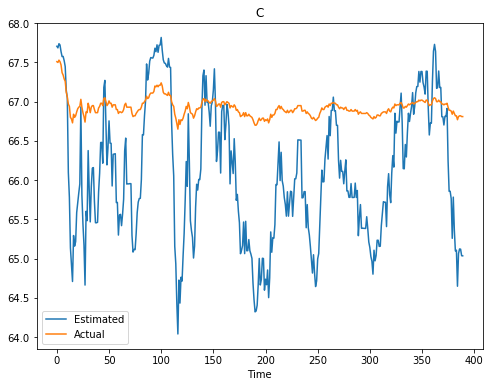

In [46]:
ex3(file_objs[1], 'C')

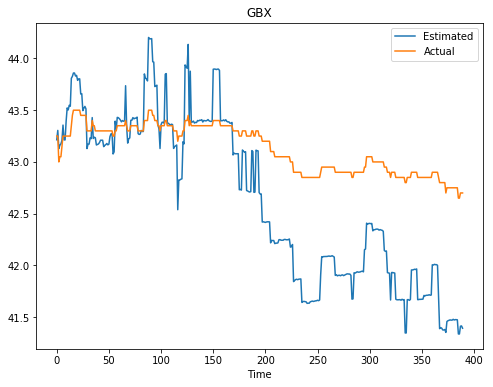

In [47]:
ex3(file_objs[2], 'GBX')

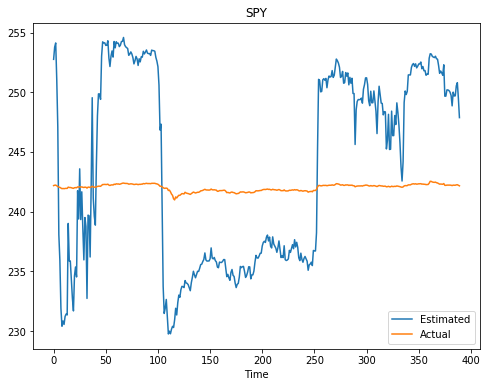

In [48]:
ex3(file_objs[3], 'SPY')

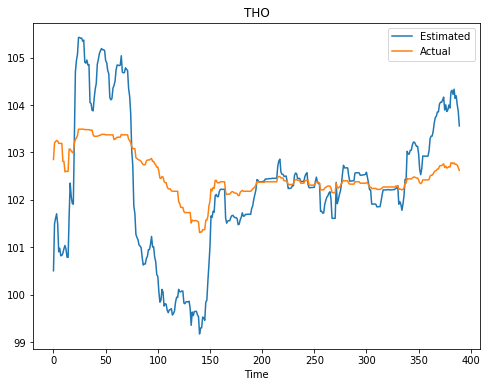

In [49]:
ex3(file_objs[4], 'THO')

The estimated value appears to behave much more eratic than the actual midpoint of the BBO over time. 

**EXERCISE 4**

It is to be expected that the volatility of the tickers and the estimation error of p is correlated. This is also what we observe in the plots.